# Do you need psuedo labels?

# You might need a token for space itself? start and stop tokens?

# Sentiment Classification model with test as well in train? Will increase the vocab size as well?

# * https://www.tensorflow.org/tutorials/text/transformer
# * https://pytorch.org/tutorials/beginner/transformer_tutorial.html

## Settings

In [1]:
# CONTROLS
MODEL_PREFIX = "V11"
MODEL_NUMBER = MODEL_PREFIX[-2:]
TRAIN_SPLIT_RATIO = 0.8

DROPOUT = 0.3
MIN_LR = 1e-6
MAX_LR = 1e-3
BATCH_SIZE = 1024
PREDICT_BATCH_SIZE = 2048
STEP_SIZE = 10
CLR_METHOD = "triangular2" # exp_range, triangular, triangular2
NUM_EPOCHS = 200

## Libraries

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

#from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight

import pickle, os, sys, re

import spacy
from spacy.lang.en import English

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv1D, Conv2D, LSTM, Embedding, Dense, concatenate, MaxPooling2D, Softmax, Flatten
from tensorflow.keras.layers import BatchNormalization, Dropout, Reshape, Activation, Bidirectional, TimeDistributed
from tensorflow.keras.layers import RepeatVector, Multiply
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer

def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

%matplotlib inline

In [3]:
from tensorflow.keras.callbacks import *
import tensorflow.keras.backend as K

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [4]:
pd.set_option('display.max_colwidth', -1)
np.random.seed(54321)

c:\users\deepak\miniconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


## Import Data

In [5]:
df = pd.read_csv("../data/train.csv",
                 dtype={"time":np.float64,"signal":np.float64,"open_channels":np.int16},
                 encoding="utf8")

df2 = pd.read_csv("../data/train.csv",
                 dtype={"time":np.float64,"signal":np.float64,"open_channels":np.int16})

print(pd.concat((df.dtypes, df.isna().sum()), axis=1))
print(df.shape)

# Counts of various columns
print({i:df[i].nunique() for i in df.columns})
print(df.describe()) #.astype(int)
df.head(2)

                    0  1
textID         object  0
text           object  1
selected_text  object  1
sentiment      object  0
(27481, 4)
{'textID': 27481, 'text': 27480, 'selected_text': 22463, 'sentiment': 3}
            textID  \
count   27481        
unique  27481        
top     0257d899c7   
freq    1            

                                                                                                                             text  \
count   27480                                                                                                                       
unique  27480                                                                                                                       
top      - Yeah I know they are **** annoying with that... But it,s such good promo... I lost some contacts for business in there   
freq    1                                                                                                                           

       selecte

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative


In [6]:
test_df = pd.read_csv("../data/test.csv", dtype={"time":np.float64,"signal":np.float64})
print(pd.concat((test_df.dtypes, test_df.isna().sum()), axis=1))
print(test_df.shape)

# Counts of various columns
print({i:test_df[i].nunique() for i in test_df.columns})
print(test_df.describe())
test_df.head(2)

                0  1
textID     object  0
text       object  0
sentiment  object  0
(3534, 3)
{'textID': 3534, 'text': 3534, 'sentiment': 3}
            textID  \
count   3534         
unique  3534         
top     5921dbcbf3   
freq    1            

                                                                                                                                             text  \
count   3534                                                                                                                                        
unique  3534                                                                                                                                        
top     Hmm...Whilst, walking through the city I received an inviataion into an SUV Limo via some prom fellows... Don`t they have dates? Oh boys!   
freq    1                                                                                                                                           

  

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -- skyscrapers galore). Good tweeps in China: (SH) (BJ).,positive


In [7]:
df.loc[df2['text'].astype('str').apply(lambda x : len(re.findall(pattern="ï¿½", string=x))>0)].head(2)

,textID,text,selected_text,sentiment
44,c77717b103,I love to! But I`m only available from 5pm. and where dear? Would love to help convert her vids.ï¿½,I love to!,positive
192,28dbada620,*phew* Will make a note in case anyone else runs into the same issueï¿½,*phew* Will make a note in case anyone else runs into the same issueï¿½,neutral


In [8]:
test_df.loc[test_df['text'].astype('str').apply(lambda x : len(re.findall(pattern="ï¿½", string=x))>0)].head(2)

,textID,text,sentiment
145,7223fdccc2,tikcets are only ï¿½91...each...BUT I SO WANT TO GO,positive
618,43ad351369,"AHHH - Whatchu talkinï¿½ baby? HAHAHA I canï¿½t believe youu:O heh, actually I can. Life is worth taking risks... http://tumblr.com/xs81qy54s",positive


## Exploration

#### Sentiment count in training

In [9]:
pd.concat([df.groupby("sentiment")[["text"]].count(), test_df.groupby("sentiment")[["text"]].count()], axis=1)

,text,text
sentiment,,
negative,7781,1001
neutral,11117,1430
positive,8582,1103


## Preprocessing

#### Cleaning

In [10]:
# For traceability
df["original_index"] = df.index
test_df["original_index"] = test_df.index

In [11]:
print(df.shape)
df = df[(~df.text.isna())]
df = df.reset_index(drop=True)
df = df.copy()
print(df.shape)

(27481, 5)
(27480, 5)


In [12]:
df["sentiment_code"] = df["sentiment"].astype("category")
X_sentiments = df["sentiment_code"].cat.codes.values

test_df["sentiment_code"] = test_df["sentiment"].astype("category")
X_sentiments_test = test_df["sentiment_code"].cat.codes.values

In [13]:
df["text"] = df["text"].astype(str)
df["selected_text"] = df["selected_text"].astype(str)
test_df["text"] = test_df["text"].astype(str)

#### Tagging

In [14]:
def preprocess_text(x, extra_string=None):
    x = x.lower()
    x = re.sub('([!"#$%&()*+,-./:;\'<=>?@[\\]^_{|}~\t\n])', ' \\1 ', x) # Not including ` here since used in couldn`t, isn`t
    x = x.strip()
    x = re.sub(' +', ' ', x)
    x = x.split(" ")
    if extra_string is not None:
        x = ["xxxSTART"] + x + ["xxxSENTIMENT"] + [extra_string] + ["xxxEND"]
    return x

In [15]:
def get_extremities(l_string, s_string, extra_string, print_it=False):
    l_string = preprocess_text(l_string, extra_string)
    s_string = preprocess_text(s_string, extra_string=None)
    
    len_l = len(l_string)
    len_s = len(s_string)
    
    for i in range(len_l - len_s + 1):
        if (i + len_s) <= len_l:
            substring = l_string[i:i+len_s]
            if substring == s_string:
                if print_it:
                    print(l_string)
                    print(substring)
                    print(i, i+len_s, substring)
                
                start_vector, end_vector = np.zeros(len_l, dtype=np.int16), np.zeros(len_l, dtype=np.int16)
                att_vector = np.ones(len_l, dtype=np.int16)
                start_vector[i], end_vector[i+len_s-1] = 1, 1
                
                return (l_string, s_string, start_vector, end_vector, att_vector)

In [16]:
idx = 100
get_extremities(df.text[idx], df.selected_text[idx], df.sentiment[idx], print_it=False)

(['xxxSTART',
  '4am',
  '.',
  'and',
  'im',
  'on',
  'the',
  'beach',
  '.',
  'pretty',
  'xxxSENTIMENT',
  'positive',
  'xxxEND'],
 ['pretty'],
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int16),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int16),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int16))

In [17]:
df[["text_mod", "selected_text_mod", "target_start", "target_stop", "target_atten"]] = df.apply(lambda x: get_extremities(x.text, x.selected_text, x.sentiment), axis=1).apply(pd.Series)
test_df[["text_mod"]] = test_df.apply(lambda x: [preprocess_text(x.text, extra_string = x.sentiment)], axis=1).apply(pd.Series)

In [18]:
df.isna().sum()

textID               0   
text                 0   
selected_text        0   
sentiment            0   
original_index       0   
sentiment_code       0   
text_mod             1476
selected_text_mod    1476
target_start         1476
target_stop          1476
target_atten         1476
dtype: int64

In [19]:
test_df.isna().sum()

textID            0
text              0
sentiment         0
original_index    0
sentiment_code    0
text_mod          0
dtype: int64

In [20]:
df.head(2)

,textID,text,selected_text,sentiment,original_index,sentiment_code,text_mod,selected_text_mod,target_start,target_stop,target_atten
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,0,neutral,"[xxxSTART, i`d, have, responded, ,, if, i, were, going, xxxSENTIMENT, neutral, xxxEND]","[i`d, have, responded, ,, if, i, were, going]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,1,negative,"[xxxSTART, sooo, sad, i, will, miss, you, here, in, san, diego, !, !, !, xxxSENTIMENT, negative, xxxEND]","[sooo, sad]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"


In [21]:
df.iloc[df.loc[df['target_start'].isna()].index].head(2)

,textID,text,selected_text,sentiment,original_index,sentiment_code,text_mod,selected_text_mod,target_start,target_stop,target_atten
18,af3fed7fc3,is back home now gonna miss every one,onna,negative,18,negative,NaN,NaN,NaN,NaN,NaN
32,1c31703aef,If it is any consolation I got my BMI tested hahaha it says I am obesed well so much for being unhappy for about 10 minutes.,well so much for being unhappy for about 10 minute,negative,32,negative,NaN,NaN,NaN,NaN,NaN


In [22]:
test_df.head(2)

,textID,text,sentiment,original_index,sentiment_code,text_mod
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,0,neutral,"[xxxSTART, last, session, of, the, day, http, :, /, /, twitpic, ., com, /, 67ezh, xxxSENTIMENT, neutral, xxxEND]"
1,96d74cb729,Shanghai is also really exciting (precisely -- skyscrapers galore). Good tweeps in China: (SH) (BJ).,positive,1,positive,"[xxxSTART, shanghai, is, also, really, exciting, (, precisely, -, -, skyscrapers, galore, ), ., good, tweeps, in, china, :, (, sh, ), (, bj, ), ., xxxSENTIMENT, positive, xxxEND]"


In [23]:
anomalous_idxs = df.loc[df['target_start'].isna()].index.tolist()

In [24]:
print(df.shape)
df = df[~df.index.isin(anomalous_idxs)]
df = df.reset_index(drop=True)
df = df.copy()
print(df.shape)

(27480, 11)
(26004, 11)


#### Tokenization

In [25]:
X_words = df['text_mod'].apply(lambda x:list(x)).tolist()
X_att = df['target_atten'].apply(lambda x:list(x)).tolist()

X_words_test = test_df['text_mod'].apply(lambda x:list(x)).tolist()
X_att_test = [[1 for j in i] for i in X_words_test]

Y_words = df['selected_text_mod'].apply(lambda x:list(x)).tolist()
Y_starts = df['target_start'].apply(lambda x:list(x)).tolist()
Y_stops = df['target_stop'].apply(lambda x:list(x)).tolist()

print("\n",
    "X_words:","\t", len(X_words),"\n",
    "X_att:","\t", len(X_att),"\n",
    "Y_words:","\t", len(Y_words),"\n",
    "Y_starts:","\t", len(Y_starts),"\n",
    "Y_stops:","\t", len(Y_stops),"\n",
    "X_words_test:","\t", len(X_words_test),"\n",
    "X_att_test:","\t", len(X_att_test),"\n"
)


 X_words: 	 26004 
 X_att: 	 26004 
 Y_words: 	 26004 
 Y_starts: 	 26004 
 Y_stops: 	 26004 
 X_words_test: 	 3534 
 X_att_test: 	 3534 



In [26]:
print(sum([len(i)==len(j) for i,j in zip(X_att_test, X_words_test)]))
print(sum([len(i)==len(j) for i,j in zip(X_att, X_words)]))

3534
26004


In [27]:
from collections import Counter
word_counts = Counter([j for i in X_words for j in i])

X_unique_tokens = len(word_counts)
word_counts.most_common(10)

[('.', 33619),
 ('xxxSTART', 26004),
 ('xxxSENTIMENT', 26004),
 ('xxxEND', 26004),
 ('!', 14379),
 ('i', 12615),
 ('neutral', 10941),
 ('to', 9447),
 ('the', 8445),
 (',', 7984)]

In [28]:
MIN_WORD_FREQ = 2

In [29]:
word_subset = [i for i,j in word_counts.items() if j >= MIN_WORD_FREQ]
print("VOCAB reduced from", len(word_counts), "to", len(word_subset))

VOCAB reduced from 25847 to 10178


In [30]:
#list_of_words = set(sorted([j for i in X_words for j in i]))
#Y_list_of_words = set(sorted([j for i in Y_words for j in i]))

In [31]:
vocab_itos = {i+2:j for i,j in enumerate(word_subset)}
vocab_stoi = {j:i+2 for i,j in enumerate(word_subset)}

vocab_stoi["xxxUNK"] = 1
vocab_itos[1] = "xxxUNK"

vocab_stoi["xxxNone"] = 0
vocab_itos[0] = "xxxNone"

In [32]:
def get_from_vocab(vocab, word):
    try:
        value = vocab[word]
    except KeyError as k:
        value = vocab_stoi["xxxUNK"]
    return value

In [33]:
X = [[get_from_vocab(vocab_stoi,j) for j in i] for i in X_words]
Y = [[get_from_vocab(vocab_stoi,j) for j in i] for i in Y_words]
X_test = [[get_from_vocab(vocab_stoi,j) for j in i] for i in X_words_test]

In [34]:
max_len = max([len(i) for i in X])
VOCAB_SIZE = len(vocab_stoi)
print(VOCAB_SIZE, max_len)

10180 110


#### Train Validation  split

In [35]:
idx = [i for i in np.arange(len(Y))]
np.random.shuffle(idx)
train_idx, val_idx = idx[:round(TRAIN_SPLIT_RATIO*len(Y))], idx[round(TRAIN_SPLIT_RATIO * len(Y)):]

print(len(idx), len(train_idx), len(val_idx), len(train_idx) + len(val_idx))

26004 20803 5201 26004


In [36]:
X_train, X_val = [X[i] for i in train_idx], [X[i] for i in val_idx]
X_att_train, X_att_val = [X_att[i] for i in train_idx], [X_att[i] for i in val_idx]

Y_train, Y_val = [Y[i] for i in train_idx], [Y[i] for i in val_idx]
Y_starts_train, Y_starts_val = [Y_starts[i] for i in train_idx], [Y_starts[i] for i in val_idx]
Y_stops_train, Y_stops_val = [Y_stops[i] for i in train_idx], [Y_stops[i] for i in val_idx]

print("\n",
    len(X_train),"\t",": X_train","\n",
    len(X_att_train),"\t",": X_att_train","\n",
    len(Y_train),"\t",": Y_train","\n",
    len(Y_starts_train),"\t",": Y_starts_train","\n",
    len(Y_stops_train),"\t",": Y_stops_train","\n",
    len(X_val),"\t",": X_val","\n",
    len(X_att_val),"\t",": X_att_val","\n",
    len(Y_val),"\t",": Y_val","\n",
    len(Y_starts_val),"\t",": Y_starts_val","\n",
    len(Y_stops_val),"\t",": Y_stops_val","\n"
)


 20803 	 : X_train 
 20803 	 : X_att_train 
 20803 	 : Y_train 
 20803 	 : Y_starts_train 
 20803 	 : Y_stops_train 
 5201 	 : X_val 
 5201 	 : X_att_val 
 5201 	 : Y_val 
 5201 	 : Y_starts_val 
 5201 	 : Y_stops_val 



#### Padding

In [37]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [38]:
X_train = pad_sequences(X_train, maxlen=max_len, padding="post")
X_att_train = pad_sequences(X_att_train, maxlen=max_len, padding="post")
Y_train = pad_sequences(Y_train, maxlen=max_len, padding="post")
Y_starts_train = pad_sequences(Y_starts_train, maxlen=max_len, padding="post")
Y_stops_train = pad_sequences(Y_stops_train, maxlen=max_len, padding="post")

X_val = pad_sequences(X_val, maxlen=max_len, padding="post")
X_att_val = pad_sequences(X_att_val, maxlen=max_len, padding="post")
Y_val = pad_sequences(Y_val, maxlen=max_len, padding="post")
Y_starts_val = pad_sequences(Y_starts_val, maxlen=max_len, padding="post")
Y_stops_val = pad_sequences(Y_stops_val, maxlen=max_len, padding="post")

X_test = pad_sequences(X_test, maxlen=max_len, padding="post")
X_att_test = pad_sequences(X_att_test, maxlen=max_len, padding="post")

In [39]:
print("\n",
     X_train.shape, "\t: X_train ", "\n",
     X_att_train.shape, "\t: X_att_train ", "\n",
     Y_train.shape, "\t: Y_train ", "\n",
     Y_starts_train.shape, "\t: Y_starts_train ", "\n",
     Y_stops_train.shape, "\t: Y_stops_train ", "\n",

     X_val.shape, "\t: X_val ", "\n",
     X_att_val.shape, "\t: X_att_val ", "\n",
     Y_val.shape, "\t: Y_val ", "\n",
     Y_starts_val.shape, "\t: Y_starts_val ", "\n",
     Y_stops_val.shape, "\t: Y_stops_val ", "\n",

     X_test.shape, "\t: X_test ", "\n",
     X_att_test.shape, "\t: X_att_test ", "\n"
)


 (20803, 110) 	: X_train  
 (20803, 110) 	: X_att_train  
 (20803, 110) 	: Y_train  
 (20803, 110) 	: Y_starts_train  
 (20803, 110) 	: Y_stops_train  
 (5201, 110) 	: X_val  
 (5201, 110) 	: X_att_val  
 (5201, 110) 	: Y_val  
 (5201, 110) 	: Y_starts_val  
 (5201, 110) 	: Y_stops_val  
 (3534, 110) 	: X_test  
 (3534, 110) 	: X_att_test  



#### Checking for zero input vectors

In [40]:
print(np.argmax([X_train.sum(axis=1)==0]), np.min([X_train.sum(axis=1)]))
print(np.argmax([X_val.sum(axis=1)==0]), np.min([X_val.sum(axis=1)]))

0 36
0 36


#### Check inputs and outputs

In [41]:
#Train
num = 100
[[i,j,k,l,m] for i,j,k,l,m in zip(X_train[num],
                                  X_att_train[num],
                                  Y_train[num],
                                  Y_starts_train[num],
                                  Y_stops_train[num])]

[[2, 1, 1662, 0, 0],
 [87, 1, 648, 0, 0],
 [17, 1, 2533, 0, 0],
 [2174, 1, 7, 0, 0],
 [669, 1, 1685, 0, 0],
 [84, 1, 278, 0, 0],
 [1662, 1, 17, 1, 0],
 [648, 1, 229, 0, 0],
 [2533, 1, 4625, 0, 0],
 [7, 1, 116, 0, 0],
 [1685, 1, 44, 0, 0],
 [278, 1, 406, 0, 0],
 [17, 1, 8227, 0, 0],
 [229, 1, 0, 0, 0],
 [4625, 1, 0, 0, 0],
 [116, 1, 0, 0, 0],
 [44, 1, 0, 0, 0],
 [406, 1, 0, 0, 0],
 [8227, 1, 0, 0, 1],
 [7492, 1, 0, 0, 0],
 [10, 1, 0, 0, 0],
 [11, 1, 0, 0, 0],
 [12, 1, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 

In [42]:
#Val
num = 100
[[i,j,k,l,m] for i,j,k,l,m in zip(X_val[num],
                                  X_att_val[num],
                                  Y_val[num],
                                  Y_starts_val[num],
                                  Y_stops_val[num])]

[[2, 1, 9890, 0, 0],
 [9890, 1, 8753, 1, 0],
 [8753, 1, 55, 0, 0],
 [55, 1, 4465, 0, 0],
 [4465, 1, 305, 0, 0],
 [305, 1, 1, 0, 0],
 [1, 1, 28, 0, 0],
 [28, 1, 0, 0, 1],
 [47, 1, 0, 0, 0],
 [48, 1, 0, 0, 0],
 [49, 1, 0, 0, 0],
 [49, 1, 0, 0, 0],
 [50, 1, 0, 0, 0],
 [28, 1, 0, 0, 0],
 [1, 1, 0, 0, 0],
 [28, 1, 0, 0, 0],
 [51, 1, 0, 0, 0],
 [49, 1, 0, 0, 0],
 [1, 1, 0, 0, 0],
 [49, 1, 0, 0, 0],
 [9890, 1, 0, 0, 0],
 [28, 1, 0, 0, 0],
 [7327, 1, 0, 0, 0],
 [10, 1, 0, 0, 0],
 [11, 1, 0, 0, 0],
 [12, 1, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],


In [43]:
#Test
num = 100
[[i,j,k] for i,j,k in zip(X_words_test[num],
                          X_test[num],
                          X_att_test[num])]

[['xxxSTART', 2, 1],
 ['oooh', 3482, 1],
 [',', 5, 1],
 ['sunshine', 1726, 1],
 ['!', 22, 1],
 ['a', 142, 1],
 ['patch', 905, 1],
 ['of', 34, 1],
 ['sunshine', 1726, 1],
 ['!', 22, 1],
 ['and', 68, 1],
 ['it', 144, 1],
 ['will', 15, 1],
 ['be', 89, 1],
 ['gone', 544, 1],
 ['by', 106, 1],
 ['the', 42, 1],
 ['time', 504, 1],
 ['i', 7, 1],
 ['leave', 31, 1],
 ['work', 342, 1],
 ['and', 68, 1],
 ['replaced', 1, 1],
 ['with', 278, 1],
 ['rain', 1901, 1],
 ['.', 28, 1],
 ['/', 49, 1],
 ['vent', 9146, 1],
 ['xxxSENTIMENT', 10, 1],
 ['neutral', 11, 1],
 ['xxxEND', 12, 1]]

## Model

In [44]:
input_att_flags = Input((max_len), name="att_flags")
input_sequences = Input((max_len), name="words")

emb_sequences = Embedding(input_dim=VOCAB_SIZE, input_length=max_len, output_dim=64, mask_zero=True)(input_sequences)

seq = Bidirectional(LSTM(16, activation=None, return_sequences=True))(emb_sequences)
seq = BatchNormalization()(seq)
seq = Activation("relu")(seq)
seq = Dropout(DROPOUT)(seq)

seq = Bidirectional(LSTM(16, activation=None, return_sequences=False))(seq)
seq = BatchNormalization()(seq)
seq = Activation("relu")(seq)
seq = Dropout(DROPOUT)(seq)

seq = Dense(max_len, activation="relu")(seq)
seq = BatchNormalization()(seq)
seq = Dropout(DROPOUT)(seq)

att = Dense(max_len, activation="relu")(input_att_flags)
att = BatchNormalization()(att)
att = Dropout(DROPOUT)(att)

convs = Conv1D(filters=32, kernel_size=8, padding="same", activation=None)(emb_sequences)
convs = BatchNormalization()(convs)
convs = Activation("relu")(convs)
convs = Dropout(DROPOUT)(convs)

convs = Conv1D(filters=32, kernel_size=8, padding="same", activation=None)(convs)
convs = BatchNormalization()(convs)
convs = Activation("relu")(convs)
convs = Dropout(DROPOUT)(convs)

convs = Flatten()(convs)
convs = Dense(max_len, activation=None)(convs)
convs = BatchNormalization()(convs)
convs = Activation("relu")(convs)
convs = Dropout(DROPOUT)(convs)

conv = Multiply()([att, convs])
seq = Multiply()([att, seq])
concat_layer = concatenate([conv, seq])

output_starts = Dense(max_len, activation=None)(concat_layer)
output_starts = BatchNormalization()(output_starts)
output_starts = Activation("relu")(output_starts)

output_stops = Dense(max_len, activation=None)(concat_layer)
output_stops = BatchNormalization()(output_stops)
output_stops = Activation("relu")(output_stops)

output_starts = Dense(max_len, activation='softmax', name="starts")(output_starts)
output_stops = Dense(max_len, activation='softmax', name="stops")(output_stops)

In [45]:
model = Model([input_att_flags, input_sequences], [output_starts, output_stops])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words (InputLayer)              [(None, 110)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 110, 64)      651520      words[0][0]                      
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 110, 32)      16416       embedding[0][0]                  
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 110, 32)      128         conv1d[0][0]                     
______________________________________________________________________________________________

In [46]:
adam = Adam(learning_rate=MIN_LR)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=adam , metrics=['accuracy'])

In [47]:
#callbacks
mcp = ModelCheckpoint(filepath="../results/"+MODEL_PREFIX+"BestCheckpoint.h5",
                      monitor='val_loss',
                      mode="auto",
                      save_weights_only=False,
                      save_best_only=True)

clr = CyclicLR(mode=CLR_METHOD,
               base_lr=MIN_LR,
               max_lr=MAX_LR,
               step_size= STEP_SIZE * (X_train.shape[0] // BATCH_SIZE))

In [48]:
history = model.fit(x={"att_flags":X_att_train,
                       "words":X_train},
                    y={"starts":Y_starts_train.argmax(axis=1),
                       "stops":Y_stops_train.argmax(axis=1)},
                    shuffle=True,
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    validation_data=({"att_flags":X_att_val, "words":X_val},
                                     {"starts":Y_starts_val.argmax(axis=1), "stops":Y_stops_val.argmax(axis=1)}),
                    verbose=1,
                    callbacks=[clr, mcp]) #es, rlrop, tb, mcp,

Train on 20803 samples, validate on 5201 samples
Epoch 1/200
20803/20803 [==============================] - 25s 1ms/sample - loss: 9.8364 - starts_loss: 4.9002 - stops_loss: 4.9330 - starts_accuracy: 0.0117 - stops_accuracy: 0.0170 - val_loss: 9.3949 - val_starts_loss: 4.6973 - val_stops_loss: 4.6976 - val_starts_accuracy: 1.9227e-04 - val_stops_accuracy: 0.0179
Epoch 2/200
20803/20803 [==============================] - 13s 626us/sample - loss: 9.5058 - starts_loss: 4.7483 - stops_loss: 4.7469 - starts_accuracy: 0.0215 - stops_accuracy: 0.0312 - val_loss: 9.3647 - val_starts_loss: 4.6818 - val_stops_loss: 4.6833 - val_starts_accuracy: 0.0171 - val_stops_accuracy: 0.0300
Epoch 3/200
20803/20803 [==============================] - 14s 671us/sample - loss: 8.8410 - starts_loss: 4.4273 - stops_loss: 4.3940 - starts_accuracy: 0.0855 - stops_accuracy: 0.0763 - val_loss: 9.3035 - val_starts_loss: 4.6593 - val_stops_loss: 4.6455 - val_starts_accuracy: 0.1604 - val_stops_accuracy: 0.0846
Epoch 4

Epoch 27/200
20803/20803 [==============================] - 14s 685us/sample - loss: 2.6181 - starts_loss: 1.2958 - stops_loss: 1.3210 - starts_accuracy: 0.6165 - stops_accuracy: 0.6403 - val_loss: 3.4431 - val_starts_loss: 1.7441 - val_stops_loss: 1.7314 - val_starts_accuracy: 0.5605 - val_stops_accuracy: 0.5820
Epoch 28/200
20803/20803 [==============================] - 13s 615us/sample - loss: 2.5552 - starts_loss: 1.2699 - stops_loss: 1.2946 - starts_accuracy: 0.6234 - stops_accuracy: 0.6466 - val_loss: 3.4215 - val_starts_loss: 1.7547 - val_stops_loss: 1.6959 - val_starts_accuracy: 0.5528 - val_stops_accuracy: 0.5810
Epoch 29/200
20803/20803 [==============================] - 13s 626us/sample - loss: 2.4726 - starts_loss: 1.2250 - stops_loss: 1.2412 - starts_accuracy: 0.6289 - stops_accuracy: 0.6556 - val_loss: 3.3274 - val_starts_loss: 1.7410 - val_stops_loss: 1.6153 - val_starts_accuracy: 0.5462 - val_stops_accuracy: 0.5901
Epoch 30/200
20803/20803 [=============================

20803/20803 [==============================] - 13s 611us/sample - loss: 1.7489 - starts_loss: 0.9167 - stops_loss: 0.8299 - starts_accuracy: 0.7114 - stops_accuracy: 0.7578 - val_loss: 3.0284 - val_starts_loss: 1.5256 - val_stops_loss: 1.4668 - val_starts_accuracy: 0.5822 - val_stops_accuracy: 0.6203
Epoch 54/200
20803/20803 [==============================] - 13s 614us/sample - loss: 1.7372 - starts_loss: 0.9115 - stops_loss: 0.8288 - starts_accuracy: 0.7086 - stops_accuracy: 0.7584 - val_loss: 3.0155 - val_starts_loss: 1.5255 - val_stops_loss: 1.4598 - val_starts_accuracy: 0.5841 - val_stops_accuracy: 0.6208
Epoch 55/200
20803/20803 [==============================] - 12s 600us/sample - loss: 1.7260 - starts_loss: 0.8999 - stops_loss: 0.8252 - starts_accuracy: 0.7160 - stops_accuracy: 0.7621 - val_loss: 3.0355 - val_starts_loss: 1.5228 - val_stops_loss: 1.4758 - val_starts_accuracy: 0.5849 - val_stops_accuracy: 0.6241
Epoch 56/200
20803/20803 [==============================] - 13s 605u

20803/20803 [==============================] - 14s 667us/sample - loss: 1.5518 - starts_loss: 0.8299 - stops_loss: 0.7190 - starts_accuracy: 0.7344 - stops_accuracy: 0.7886 - val_loss: 3.1221 - val_starts_loss: 1.5483 - val_stops_loss: 1.5293 - val_starts_accuracy: 0.5843 - val_stops_accuracy: 0.6231
Epoch 80/200
20803/20803 [==============================] - 13s 648us/sample - loss: 1.5517 - starts_loss: 0.8259 - stops_loss: 0.7284 - starts_accuracy: 0.7380 - stops_accuracy: 0.7894 - val_loss: 3.1221 - val_starts_loss: 1.5472 - val_stops_loss: 1.5315 - val_starts_accuracy: 0.5870 - val_stops_accuracy: 0.6226
Epoch 81/200
20803/20803 [==============================] - 13s 622us/sample - loss: 1.5512 - starts_loss: 0.8289 - stops_loss: 0.7205 - starts_accuracy: 0.7347 - stops_accuracy: 0.7857 - val_loss: 3.1280 - val_starts_loss: 1.5510 - val_stops_loss: 1.5338 - val_starts_accuracy: 0.5870 - val_stops_accuracy: 0.6224
Epoch 82/200
20803/20803 [==============================] - 13s 616u

20803/20803 [==============================] - 13s 631us/sample - loss: 1.4722 - starts_loss: 0.7971 - stops_loss: 0.6725 - starts_accuracy: 0.7472 - stops_accuracy: 0.8014 - val_loss: 3.1758 - val_starts_loss: 1.5715 - val_stops_loss: 1.5547 - val_starts_accuracy: 0.5841 - val_stops_accuracy: 0.6237
Epoch 106/200
20803/20803 [==============================] - 13s 641us/sample - loss: 1.4707 - starts_loss: 0.7870 - stops_loss: 0.6829 - starts_accuracy: 0.7463 - stops_accuracy: 0.8007 - val_loss: 3.1677 - val_starts_loss: 1.5727 - val_stops_loss: 1.5457 - val_starts_accuracy: 0.5857 - val_stops_accuracy: 0.6222
Epoch 107/200
20803/20803 [==============================] - 13s 639us/sample - loss: 1.4645 - starts_loss: 0.7882 - stops_loss: 0.6761 - starts_accuracy: 0.7477 - stops_accuracy: 0.8002 - val_loss: 3.1717 - val_starts_loss: 1.5709 - val_stops_loss: 1.5508 - val_starts_accuracy: 0.5845 - val_stops_accuracy: 0.6235
Epoch 108/200
20803/20803 [==============================] - 14s 6

Epoch 131/200
20803/20803 [==============================] - 14s 655us/sample - loss: 1.4408 - starts_loss: 0.7792 - stops_loss: 0.6632 - starts_accuracy: 0.7525 - stops_accuracy: 0.8057 - val_loss: 3.2029 - val_starts_loss: 1.5794 - val_stops_loss: 1.5718 - val_starts_accuracy: 0.5860 - val_stops_accuracy: 0.6241
Epoch 132/200
20803/20803 [==============================] - 14s 652us/sample - loss: 1.4356 - starts_loss: 0.7763 - stops_loss: 0.6619 - starts_accuracy: 0.7508 - stops_accuracy: 0.8050 - val_loss: 3.2033 - val_starts_loss: 1.5787 - val_stops_loss: 1.5729 - val_starts_accuracy: 0.5860 - val_stops_accuracy: 0.6231
Epoch 133/200
20803/20803 [==============================] - 13s 630us/sample - loss: 1.4292 - starts_loss: 0.7747 - stops_loss: 0.6574 - starts_accuracy: 0.7520 - stops_accuracy: 0.8073 - val_loss: 3.2048 - val_starts_loss: 1.5791 - val_stops_loss: 1.5742 - val_starts_accuracy: 0.5862 - val_stops_accuracy: 0.6231
Epoch 134/200
20803/20803 [=========================

Epoch 157/200
20803/20803 [==============================] - 38s 2ms/sample - loss: 1.4255 - starts_loss: 0.7710 - stops_loss: 0.6527 - starts_accuracy: 0.7542 - stops_accuracy: 0.8084 - val_loss: 3.2158 - val_starts_loss: 1.5863 - val_stops_loss: 1.5789 - val_starts_accuracy: 0.5855 - val_stops_accuracy: 0.6222
Epoch 158/200
20803/20803 [==============================] - 28s 1ms/sample - loss: 1.4266 - starts_loss: 0.7684 - stops_loss: 0.6547 - starts_accuracy: 0.7523 - stops_accuracy: 0.8061 - val_loss: 3.2154 - val_starts_loss: 1.5867 - val_stops_loss: 1.5780 - val_starts_accuracy: 0.5855 - val_stops_accuracy: 0.6224
Epoch 159/200
20803/20803 [==============================] - 13s 606us/sample - loss: 1.4294 - starts_loss: 0.7818 - stops_loss: 0.6533 - starts_accuracy: 0.7472 - stops_accuracy: 0.8082 - val_loss: 3.2166 - val_starts_loss: 1.5867 - val_stops_loss: 1.5790 - val_starts_accuracy: 0.5849 - val_stops_accuracy: 0.6220
Epoch 160/200
20803/20803 [=============================

Epoch 183/200
20803/20803 [==============================] - 13s 609us/sample - loss: 1.4252 - starts_loss: 0.7706 - stops_loss: 0.6551 - starts_accuracy: 0.7522 - stops_accuracy: 0.8058 - val_loss: 3.2215 - val_starts_loss: 1.5893 - val_stops_loss: 1.5805 - val_starts_accuracy: 0.5866 - val_stops_accuracy: 0.6228
Epoch 184/200
20803/20803 [==============================] - 13s 608us/sample - loss: 1.4152 - starts_loss: 0.7696 - stops_loss: 0.6482 - starts_accuracy: 0.7553 - stops_accuracy: 0.8102 - val_loss: 3.2200 - val_starts_loss: 1.5886 - val_stops_loss: 1.5793 - val_starts_accuracy: 0.5858 - val_stops_accuracy: 0.6231
Epoch 185/200
20803/20803 [==============================] - 13s 609us/sample - loss: 1.4207 - starts_loss: 0.7743 - stops_loss: 0.6498 - starts_accuracy: 0.7537 - stops_accuracy: 0.8092 - val_loss: 3.2194 - val_starts_loss: 1.5888 - val_stops_loss: 1.5787 - val_starts_accuracy: 0.5860 - val_stops_accuracy: 0.6231
Epoch 186/200
20803/20803 [=========================

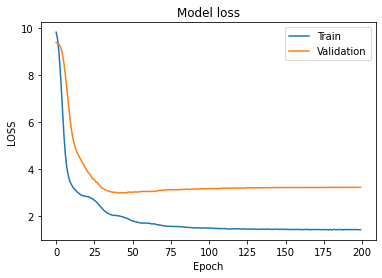

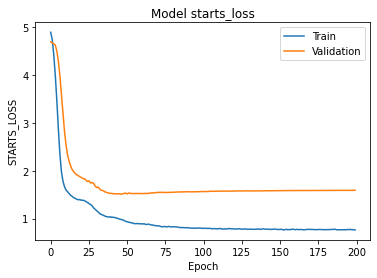

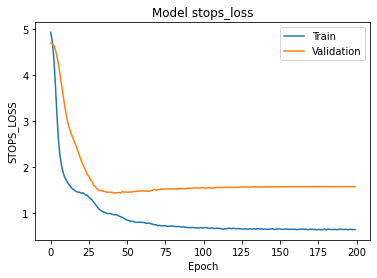

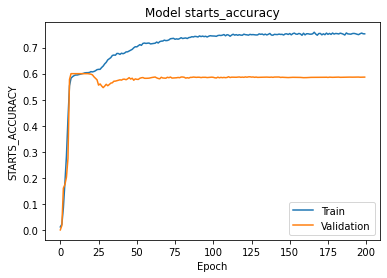

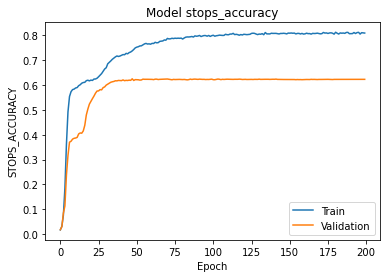

In [50]:
#metric_names = ['loss' ,'accuracy']
metric_names = ["loss", "starts_loss", "stops_loss", "starts_accuracy", "stops_accuracy"]

for i, j in zip(metric_names, ['val_'+i for i in metric_names]):
    plt.plot(history.history[i])
    plt.plot(history.history[j])
    plt.title('Model '+i)
    plt.ylabel(i.upper())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

## Validation

#### Inference

In [ ]:
end_model = model

In [84]:
end_model.save("../results/"+MODEL_PREFIX+"EndCheckpoint.h5")

In [56]:
from tensorflow.keras.models import load_model

model = tf.keras.models.load_model(
    filepath="../results/"+MODEL_PREFIX+"BestCheckpoint.h5",
    compile=True
)

In [57]:
model.evaluate(x = {"att_flags":X_att_val, "words":X_val},
               y={"starts":Y_starts_val.argmax(axis=1), "stops":Y_stops_val.argmax(axis=1)},
               batch_size=PREDICT_BATCH_SIZE)

5201/5201 [==============================] - 1s 254us/sample - loss: 2.9827 - starts_loss: 1.5264 - stops_loss: 1.4567 - starts_accuracy: 0.5787 - stops_accuracy: 0.6180


[2.9827149592324234, 1.5263637, 1.4566754, 0.5787349, 0.61795807]

In [58]:
pred_train = model.predict(x = {"att_flags":X_att_train, "words":X_train},
                           batch_size=PREDICT_BATCH_SIZE)
pred_val = model.predict(x = {"att_flags":X_att_val, "words":X_val},
                         batch_size=PREDICT_BATCH_SIZE)
pred_test = model.predict(x = {"att_flags":X_att_test, "words":X_test},
                          batch_size=PREDICT_BATCH_SIZE)

In [59]:
pred_starts_train, pred_stops_train = pred_train[0], pred_train[1]
pred_starts_val, pred_stops_val = pred_val[0], pred_val[1]
pred_starts_test, pred_stops_test = pred_test[0], pred_test[1]

In [60]:
print(pred_starts_train.shape, pred_stops_train.shape)
print(pred_starts_val.shape, pred_stops_val.shape)
print(pred_starts_test.shape, pred_stops_test.shape)

(20803, 110) (20803, 110)
(5201, 110) (5201, 110)
(3534, 110) (3534, 110)


In [61]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

In [62]:
preds = {
    "train":{
        "starts":{
            "y_true":Y_starts_train.argmax(axis=1),
            "y_pred":pred_starts_train.argmax(axis=1)
        },
        "stops":{
            "y_true":Y_stops_train.argmax(axis=1),
            "y_pred":pred_stops_train.argmax(axis=1)
        }
    },
    "valid":{
        "starts":{
            "y_true":Y_starts_val.argmax(axis=1),
            "y_pred":pred_starts_val.argmax(axis=1)
        },
        "stops":{
            "y_true":Y_stops_train.argmax(axis=1),
            "y_pred":pred_stops_train.argmax(axis=1)
        }        
    }
}

In [63]:
def print_metrics():
    funcs = [accuracy_score, f1_score, precision_score, recall_score, confusion_matrix]
    for f in funcs:
        for data_set in ["train","valid"]:
            for var in ["starts", "stops"]:
                if f in [accuracy_score]:
                    res = f(**preds[data_set][var])
                    print("{:.2f}".format(100 * res), "\t||", data_set, "\t||", var, "\t||", f.__name__)
                elif f in [confusion_matrix]:
                    res = f(**preds[data_set][var], labels = np.arange(max_len))
                    np.savetxt(X=res, fmt='%i', delimiter=",",
                               fname="../results/ConfusionMatrix_"+MODEL_PREFIX+"_"+data_set+"_"+var+".csv")
                    print("\t||", data_set, "\t||", var, "\t||", f.__name__, "\t||", 
                          "../results/ConfusionMatrix_"+MODEL_PREFIX+"_"+data_set+"_"+var+".csv")
                else:
                    res = f(**preds[data_set][var], average="macro")
                    print("{:.2f}".format(100 * res), "\t||", data_set, "\t||", var, "\t||", f.__name__)
        print("================================================================")

print_metrics()

74.07 	|| train 	|| starts 	|| accuracy_score
79.66 	|| train 	|| stops 	|| accuracy_score
57.87 	|| valid 	|| starts 	|| accuracy_score
79.66 	|| valid 	|| stops 	|| accuracy_score
25.92 	|| train 	|| starts 	|| f1_score
63.67 	|| train 	|| stops 	|| f1_score
11.56 	|| valid 	|| starts 	|| f1_score
63.67 	|| valid 	|| stops 	|| f1_score
30.95 	|| train 	|| starts 	|| precision_score
63.23 	|| train 	|| stops 	|| precision_score
12.01 	|| valid 	|| starts 	|| precision_score
63.23 	|| valid 	|| stops 	|| precision_score
27.34 	|| train 	|| starts 	|| recall_score
64.98 	|| train 	|| stops 	|| recall_score
12.52 	|| valid 	|| starts 	|| recall_score
64.98

c:\users\deepak\miniconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 	|| valid 	|| stops 	|| recall_score
	|| train 	|| starts 	|| confusion_matrix 	|| ../results/ConfusionMatrix_V11_train_starts.csv
	|| train 	|| stops 	|| confusion_matrix 	|| ../results/ConfusionMatrix_V11_train_stops.csv
	|| valid 	|| starts 	|| confusion_matrix 	|| ../results/ConfusionMatrix_V11_valid_starts.csv
	|| valid 	|| stops 	|| confusion_matrix 	|| ../results/ConfusionMatrix_V11_valid_stops.csv


#### Postprocessing

In [74]:
Y_words_train = [[vocab_itos[j] for j in i if j!=0] for num,i in enumerate(Y_train)]
Y_words_val = [[vocab_itos[j] for j in i if j!=0] for num,i in enumerate(Y_val)]

In [75]:
print(sum([s<e for s,e in zip(pred_starts_train.argmax(axis=1), pred_stops_train.argmax(axis=1))]))
print(sum([s<e for s,e in zip(pred_starts_val.argmax(axis=1), pred_stops_val.argmax(axis=1))]))
print(sum([s<e for s,e in zip(pred_starts_test.argmax(axis=1), pred_stops_test.argmax(axis=1))]))

17832
4778
3232


In [76]:
pred_words_train = [t[s:e+1] if s<e else t[e:-3] for t,s,e in zip([[vocab_itos[j] for j in i  if j!=0] for i in X_train], pred_starts_train.argmax(axis=1), pred_stops_train.argmax(axis=1))]
pred_words_val = [t[s:e+1] if s<e else t[e:-3] for t,s,e in zip([[vocab_itos[j] for j in i  if j!=0] for i in X_val], pred_starts_val.argmax(axis=1), pred_stops_val.argmax(axis=1))]
pred_words_test = [t[s:e+1] if s<e else t[e:-3] for t,s,e in zip([[vocab_itos[j] for j in i  if j!=0] for i in X_test], pred_starts_test.argmax(axis=1), pred_stops_test.argmax(axis=1))]

In [77]:
def jaccard(str1, str2):
    a = set(str1)
    b = set(str2)
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [78]:
print("Training Jaccard Score", np.mean([jaccard(str1=i, str2=j) for i,j in zip(Y_words_train, pred_words_train)]))
print("Validation Jaccard Score", np.mean([jaccard(str1=i, str2=j) for i,j in zip(Y_words_val, pred_words_val)]))

Training Jaccard Score 0.7252863016730643
Validation Jaccard Score 0.6195739765226269


In [79]:
sent_labels = {i:j for i,j in enumerate(df.sentiment_code.cat.categories)}

#### Spot Checks

In [80]:
def spot_check(index_to_check, mode):
    print("================== Sample #", index_to_check, "==================")
    if mode == "train":
        print("Selected_text:")
        print('\t', Y_words[train_idx[index_to_check]])
        print("Predicted_text:")
        print('\t', pred_words_train[index_to_check])
        print("Predictions:")
        print('\t',*[["%.2f"%j, 
                      "%.2f"%k,
                      i,
                      X_words[train_idx[index_to_check]][num]] for num, (i,j,k) in enumerate(zip(X_train[index_to_check].tolist(),
                                                                                               pred_starts_train[index_to_check].tolist(),
                                                                                               pred_stops_train[index_to_check].tolist())) if i!=0], sep="\n\t")
        
    elif mode == "validation":
        print("Selected_text:")
        print('\t', Y_words[val_idx[index_to_check]])
        print("Predicted_text:")
        print('\t', pred_words_val[index_to_check])
        print("Predictions:")
        print('\t',*[["%.2f"%j, 
                      "%.2f"%k,
                      i,
                      X_words[val_idx[index_to_check]][num]] for num, (i,j,k) in enumerate(zip(X_val[index_to_check].tolist(),
                                                                                               pred_starts_val[index_to_check].tolist(),
                                                                                               pred_stops_val[index_to_check].tolist())) if i!=0], sep="\n\t")
        
    else:
        print("Selected_text:")
        print('\t', "Not Available")
        print("Predicted_text:")
        print('\t', pred_words_test[index_to_check])
        print("Predictions:")
        print('\t',*[["%.2f"%j, 
                      "%.2f"%k,
                      i,
                      X_words_test[index_to_check][num]] for num, (i,j,k) in enumerate(zip(X_test[index_to_check].tolist(),
                                                                                               pred_starts_test[index_to_check].tolist(),
                                                                                               pred_stops_test[index_to_check].tolist())) if i!=0], sep="\n\t")

In [81]:
for i in range(10,20):
    spot_check(i, mode="train")

================== Sample # 10 ==================
Selected_text:
	 ['says', 'good', '(', 'or', 'should', 'i', 'say', 'bad', '?', ')', 'afternoon', '!']
Predicted_text:
	 ['says', 'good', '(', 'or', 'should', 'i', 'say', 'bad', '?', ')', 'afternoon', '!', 'http', ':', '/', '/', 'plurk', '.', 'com', '/', 'p', '/', 'xxxUNK']
Predictions:
	
	['0.00', '0.00', 2, 'xxxSTART']
	['0.88', '0.03', 1103, 'says']
	['0.01', '0.03', 448, 'good']
	['0.01', '0.02', 81, '(']
	['0.00', '0.02', 758, 'or']
	['0.00', '0.01', 350, 'should']
	['0.00', '0.02', 7, 'i']
	['0.01', '0.03', 460, 'say']
	['0.01', '0.03', 318, 'bad']
	['0.01', '0.06', 74, '?']
	['0.01', '0.14', 84, ')']
	['0.01', '0.04', 1434, 'afternoon']
	['0.01', '0.18', 22, '!']
	['0.00', '0.02', 47, 'http']
	['0.00', '0.01', 48, ':']
	['0.00', '0.01', 49, '/']
	['0.00', '0.01', 49, '/']
	['0.00', '0.01', 376, 'plurk']
	['0.00', '0.01', 28, '.']
	['0.00', '0.01', 51, 'com']
	['0.00', '0.00', 49, '/']
	['0.00', '0.01', 95, 'p']
	['0.00', '0.02', 4

In [82]:
for i in range(200,210):
    spot_check(i, mode="validation")

================== Sample # 200 ==================
Selected_text:
	 ['bad', 'day', 'the', 'day', 'you', 'realize', 'what', 'mess', 'you`ve', 'put', 'me', 'through', 'will', 'be', 'one', 'of', 'the', 'happiest', 'days', 'of', 'my', 'life', '.', '.', '.']
Predicted_text:
	 ['bad', 'day', 'the', 'day', 'you', 'realize', 'what', 'mess', 'you`ve', 'put', 'me', 'through', 'will', 'be', 'one', 'of', 'the', 'happiest', 'days', 'of', 'my', 'life', '.', '.', '.']
Predictions:
	
	['0.00', '0.00', 2, 'xxxSTART']
	['1.00', '0.00', 318, 'bad']
	['0.00', '0.00', 286, 'day']
	['0.00', '0.00', 42, 'the']
	['0.00', '0.00', 286, 'day']
	['0.00', '0.00', 17, 'you']
	['0.00', '0.00', 972, 'realize']
	['0.00', '0.00', 29, 'what']
	['0.00', '0.00', 345, 'mess']
	['0.00', '0.00', 973, 'you`ve']
	['0.00', '0.00', 39, 'put']
	['0.00', '0.00', 27, 'me']
	['0.00', '0.00', 247, 'through']
	['0.00', '0.00', 15, 'will']
	['0.00', '0.00', 89, 'be']
	['0.00', '0.00', 310, 'one']
	['0.00', '0.00', 34, 'of']
	['0.00', '

In [83]:
for i in range(10,20):
    spot_check(i, mode="test")

================== Sample # 10 ==================
Selected_text:
	 Not Available
Predicted_text:
	 ['total', 'bummer']
Predictions:
	
	['0.00', '0.00', 2, 'xxxSTART']
	['0.02', '0.00', 24, 'my']
	['0.01', '0.00', 977, 'bike']
	['0.00', '0.00', 183, 'was']
	['0.00', '0.00', 39, 'put']
	['0.00', '0.00', 41, 'on']
	['0.00', '0.00', 3270, 'hold']
	['0.00', '0.00', 28, '.']
	['0.00', '0.00', 28, '.']
	['0.01', '0.00', 28, '.']
	['0.01', '0.00', 350, 'should']
	['0.01', '0.00', 4, 'have']
	['0.01', '0.00', 2467, 'known']
	['0.02', '0.00', 82, 'that']
	['0.03', '0.00', 28, '.']
	['0.05', '0.00', 28, '.']
	['0.09', '0.00', 28, '.']
	['0.13', '0.00', 28, '.']
	['0.21', '0.00', 1286, 'argh']
	['0.28', '0.03', 1291, 'total']
	['0.04', '0.95', 5242, 'bummer']
	['0.04', '0.00', 10, 'xxxSENTIMENT']
	['0.01', '0.00', 23, 'negative']
	['0.00', '0.00', 12, 'xxxEND']
================== Sample # 11 ==================
Selected_text:
	 Not Available
Predicted_text:
	 ['i', 'checked', '.', 'we', 'didn`t', '